## Packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style

import pandas_datareader.data as web
import datetime as dt
import statsmodels.api as sm
import warnings
import pmdarima as pm

from nsepy import get_history
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima_model import ARIMA

In [2]:
style.use('fivethirtyeight')

In [3]:
start = dt.datetime(2017,1,1)
end = dt.datetime(2020,3,5)

Using NSEapi

In [4]:
data = get_history(symbol="INFY", start=start, end=end)

In [5]:
data.to_csv('INFY_Stprice_17-20.csv')

In [6]:
data = pd.read_csv('INFY_Stprice_17-20.csv',parse_dates=['Date'],index_col='Date')

In [7]:
df = data[['Close']]

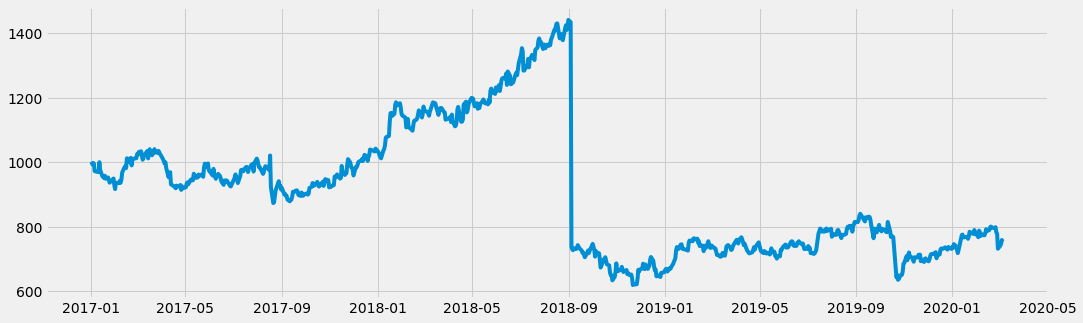

In [8]:
plt.figure(figsize=(16,5))
plt.plot(df)

By ADF we will Check for Stationarity 

In [11]:
adf = adfuller(df)
sta_result = pd.Series(adf[0:4],index=['Test Statistics','p-values','No. of Lag Used','No. of observation Used'])
for key,values in adf[4].items():
    sta_result['Critical value (%s)'%key] = values
sta_result

Test Statistics             -1.961108
p-values                     0.303882
No. of Lag Used              0.000000
No. of observation Used    785.000000
Critical value (1%)         -3.438708
Critical value (5%)         -2.865229
Critical value (10%)        -2.568734
dtype: float64

As we can see that p-values is greater then 0.05. the series is not Stationary

Taking Difference to Make Series Stationary

In [9]:
df_diff = df.diff()
df_diff.dropna(inplace=True)

Now we will check again the Stationarity 

In [12]:
adf = adfuller(df_diff)
sta_result = pd.Series(adf[0:4],index=['Test Statistics','p-values','No. of Lag Used','No. of observation Used'])
for key,values in adf[4].items():
    sta_result['Critical value (%s)'%key] = values
sta_result

Test Statistics            -27.784860
p-values                     0.000000
No. of Lag Used              0.000000
No. of observation Used    784.000000
Critical value (1%)         -3.438718
Critical value (5%)         -2.865234
Critical value (10%)        -2.568737
dtype: float64

As we can see p-values is less than 0.05.Our series is Stationary

## Now we can do a Grid Search for ADF 

In [10]:
def grid_ADF(data):
    stat = []
    reg = ['c','ct','ctt','nc']
    autolag = ['AIC', 'BIC', 't-stat', None]
    for i in range(len(reg)):
        for j in range(len(reg)):
            adf = adfuller(data,regression=reg[i],autolag=autolag[j])
            sta_result = pd.Series(adf[0:4],index=['Test Statistics','p-values','No. of Lag Used','No. of observation Used'])
            for key,values in adf[4].items():
                sta_result['Critical value (%s)'%key] = values
            stat.append(sta_result)
        print(reg[i],autolag[j],stat)
grid_ADF(df_diff)

c None [Test Statistics            -27.784860
p-values                     0.000000
No. of Lag Used              0.000000
No. of observation Used    784.000000
Critical value (1%)         -3.438718
Critical value (5%)         -2.865234
Critical value (10%)        -2.568737
dtype: float64, Test Statistics            -27.784860
p-values                     0.000000
No. of Lag Used              0.000000
No. of observation Used    784.000000
Critical value (1%)         -3.438718
Critical value (5%)         -2.865234
Critical value (10%)        -2.568737
dtype: float64, Test Statistics            -27.784860
p-values                     0.000000
No. of Lag Used              0.000000
No. of observation Used    784.000000
Critical value (1%)         -3.438718
Critical value (5%)         -2.865234
Critical value (10%)        -2.568737
dtype: float64, Test Statistics           -5.982211e+00
p-values                   1.827166e-07
No. of Lag Used            2.100000e+01
No. of observation Used   

## Split Train and Test 

In [22]:
train_size = int(len(df) * 0.80)
train, test = df[0:train_size], df[train_size:]

# Building ARIMA model

For detemining p,d,q value for our ARIMA model.We can do follow this methods 

1) Auto_Arima  

2) Hyperparameter Tuning

In [23]:
model = pm.auto_arima(train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=6092.370, BIC=6101.251, Time=0.048 seconds
Fit ARIMA: (1, 1, 0)x(0, 0, 0, 0) (constant=True); AIC=6094.284, BIC=6107.607, Time=0.078 seconds
Fit ARIMA: (0, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=6094.276, BIC=6107.598, Time=0.138 seconds
Fit ARIMA: (0, 1, 0)x(0, 0, 0, 0) (constant=False); AIC=6090.447, BIC=6094.888, Time=0.020 seconds
Fit ARIMA: (1, 1, 1)x(0, 0, 0, 0) (constant=True); AIC=6095.089, BIC=6112.852, Time=0.403 seconds
Total fit time: 0.726 seconds


Hyperparameter Tuning

In [ ]:
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
 
#load dataset

series = df
# evaluate parameters
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

## From Auto_Arima we get ARIMA: (0, 1, 0)x(0, 0, 0, 0) with lowest AIC score

Building Model

In [24]:
arima = sm.tsa.statespace.SARIMAX(train,order=(0,1,0)).fit()
arima.summary()

C:\Users\nikhi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\nikhi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  628
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3044.223
Date:                Thu, 12 Mar 2020   AIC                           6090.447
Time:                        19:43:30   BIC                           6094.888
Sample:                             0   HQIC                          6092.172
                                - 628                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       965.4240      3.839    251.462      0.000     957.899     972.949
===================================================================================
Ljung-Box (Q):                       19.73   Jarque-Bera (JB):           4228634.30
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                           -18.01
Prob(H) (two-sided):                  0.00   Kurtosis:                       403.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Checking Error using MSE

In [27]:
from sklearn.metrics import mean_squared_error
pred = arima.predict(628,786)[1:]  # imp
print('ARIMA model MSE:{}'.format(mean_squared_error(test,pred)))

ARIMA model MSE:2735.295474683545


C:\Users\nikhi\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [28]:
pred_df= pd.DataFrame(pred)
pred_df.reset_index(inplace=True)
pred_df.drop(columns='index',inplace=True)
pred_df.set_index(test.index,inplace=True)

## Ploting our Predicted and Actual values

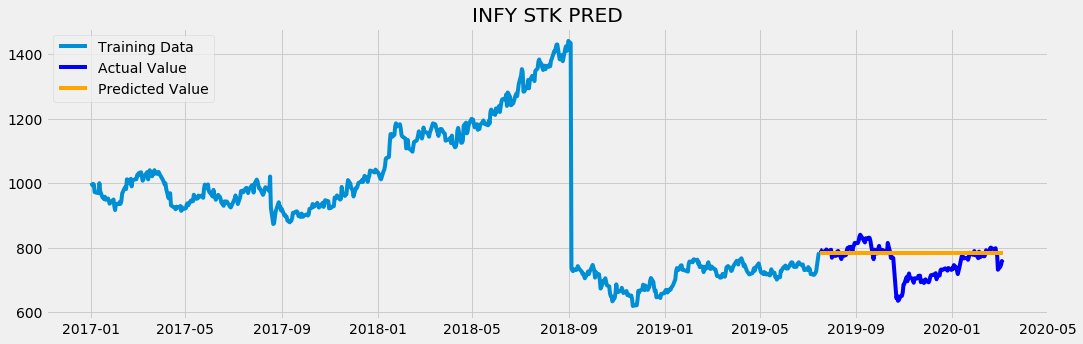

In [29]:
plt.figure(figsize=(16,5))
plt.plot(train,label ='Training Data')
plt.plot(test,label='Actual Value',color='blue')
plt.plot(pred_df,label='Predicted Value',color='orange')
plt.title('INFY STK PRED')
plt.legend(loc='upper left')
plt.show()